# LSTM

### Libraries

In [1]:
#Main Libraries
import os
import numpy as np
from numpy import mean , concatenate
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import statsmodels.api as sm
from pandas import DataFrame , concat
from pandas import read_csv
from math import sqrt

#For Custom functions
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from IPython.display import display, Math

#For Machine learning models
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Activation
from tensorflow.keras.layers import LeakyReLU

#For Data preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#For saving and loading the Machine Learning models
from tensorflow.keras.models import load_model

### Default Functions

In [2]:
def metrics(y_test, y_pred):
    """
    Computes and prints several evaluation metrics for regression models.
    
    Parameters:
    - y_test (array): True target values.
    - y_pred (array): Predicted target values from the model.
    
    Prints:
    - MSE, RMSE, MAE, R^2, and MAPE values.
    """
    # Previous metrics
    mse  = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)
    mape_values = np.where(y_test != 0, abs((y_test - y_pred) / y_test), 0)
    mape = 100 * np.mean(mape_values)
    
    print(f" MSE = {mse}\nRMSE = {rmse}\n MAE = {mae}\n  %R^2% = {r2}\n MAPE = {mape}%")

## load data temp

In [3]:
filepath = 'C:/Users/madsh/OneDrive/Dokumenter/kandidat/Fællesmappe/Speciale/Forecasting-energy-consumption-in-Denmark/Data/Combined data/'
dataset = pd.read_csv(filepath + 'combined_daily_flagged.csv')
hourdk_index = dataset['HourDK'].values #Save the index
display(dataset)

,HourDK,GrossConsumptionMWh,flagged,t2m,step_days,Is_Holiday,Day_Monday,Day_Tuesday,Day_Wednesday,Day_Thursday,...,Month_March,Month_April,Month_May,Month_June,Month_July,Month_August,Month_September,Month_October,Month_November,Month_December
0,2005-01-01,84760.194094,0,4.379644,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2005-01-02,91208.524416,0,3.912904,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2005-01-03,112086.718383,0,4.320021,2,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2005-01-04,114699.218872,0,6.146450,3,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2005-01-05,113435.680422,0,5.212295,4,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6569,2022-12-27,100264.310792,0,2.246549,179,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
6570,2022-12-28,106942.629760,0,2.202570,180,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
6571,2022-12-29,108750.475221,0,2.503690,181,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
6572,2022-12-30,108998.128298,0,2.414602,182,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [4]:
dataset = dataset[['GrossConsumptionMWh','flagged','t2m','step_days',
                   'Is_Holiday','Day_Monday','Day_Tuesday','Day_Wednesday',
                   'Day_Thursday','Day_Friday','Day_Saturday','Day_Sunday',
                   'Month_January','Month_February','Month_March','Month_April',
                   'Month_May','Month_June','Month_July','Month_August',
                   'Month_September','Month_October','Month_November',
                   'Month_December']]

#else slice is invalid for use in labelEncoder
dataset = dataset.values

# integer encode direction
encoder = LabelEncoder()
dataset[:,3] = encoder.fit_transform(dataset[:,3])

#convert to pd.Dataframe else slices error
dataset = pd.DataFrame(dataset)
dataset.columns = ['GrossConsumptionMWh','flagged','t2m','step_days',
                   'Is_Holiday','Day_Monday','Day_Tuesday','Day_Wednesday',
                   'Day_Thursday','Day_Friday','Day_Saturday','Day_Sunday',
                   'Month_January','Month_February','Month_March','Month_April',
                   'Month_May','Month_June','Month_July','Month_August',
                   'Month_September','Month_October','Month_November',
                   'Month_December']

## Data preprocessing

Split up the data into seperate objects

In [20]:
x_1  = dataset['flagged'        ].values
x_2  = dataset['t2m'            ].values
x_3  = dataset['step_days'      ].values
x_4  = dataset['Is_Holiday'     ].values
x_5  = dataset['Day_Monday'     ].values
x_6  = dataset['Day_Tuesday'    ].values
x_7  = dataset['Day_Wednesday'  ].values
x_8  = dataset['Day_Thursday'   ].values
x_9  = dataset['Day_Friday'     ].values
x_10 = dataset['Day_Saturday'   ].values
x_11 = dataset['Day_Sunday'     ].values
x_12 = dataset['Month_January'  ].values
x_13 = dataset['Month_February' ].values
x_14 = dataset['Month_March'    ].values
x_15 = dataset['Month_April'    ].values
x_16 = dataset['Month_May'      ].values
x_17 = dataset['Month_June'     ].values
x_18 = dataset['Month_July'     ].values
x_19 = dataset['Month_August'   ].values
x_20 = dataset['Month_September'].values
x_21 = dataset['Month_October'  ].values
x_22 = dataset['Month_November' ].values
x_23 = dataset['Month_December' ].values

y = dataset['GrossConsumptionMWh'].values

### Step 1: Conver to [row, columns] structure

In [21]:
# Step 1 : convert to [rows, columns] structure
x_1  = x_1.reshape((len(x_1), 1))   # flagged
x_2  = x_2.reshape((len(x_2), 1))   # t2m
x_3  = x_3.reshape((len(x_3), 1))   # step_days
x_4  = x_4.reshape((len(x_4), 1))   # Is_Holiday
x_5  = x_5.reshape((len(x_5), 1))   # Day_Monday
x_6  = x_6.reshape((len(x_6), 1))   # Day_Tuesday
x_7  = x_7.reshape((len(x_7), 1))   # Day_Wednesday
x_8  = x_8.reshape((len(x_8), 1))   # Day_Thursday
x_9  = x_9.reshape((len(x_9), 1))   # Day_Friday
x_10 = x_10.reshape((len(x_10), 1)) # Day_Saturday
x_11 = x_11.reshape((len(x_11), 1)) # Day_Sunday
x_12 = x_12.reshape((len(x_12), 1)) # Month_January
x_13 = x_13.reshape((len(x_13), 1)) # Month_February
x_14 = x_14.reshape((len(x_14), 1)) # Month_March
x_15 = x_15.reshape((len(x_15), 1)) # Month_April
x_16 = x_16.reshape((len(x_16), 1)) # Month_May
x_17 = x_17.reshape((len(x_17), 1)) # Month_June
x_18 = x_18.reshape((len(x_18), 1)) # Month_July
x_19 = x_19.reshape((len(x_19), 1)) # Month_August
x_20 = x_20.reshape((len(x_20), 1)) # Month_September
x_21 = x_21.reshape((len(x_21), 1)) # Month_October
x_22 = x_22.reshape((len(x_22), 1)) # Month_November
x_23 = x_23.reshape((len(x_23), 1)) # Month_December
y = y.reshape((len(y), 1))          # GrossConsumptionMWh

print ("x_1.shape" , x_1.shape) 
print ("x_2.shape" , x_2.shape) 
print ("y.shape" , y.shape)

x_1.shape (6574, 1)
x_2.shape (6574, 1)
y.shape (6574, 1)


### Step 2: Normalization (only on continues variables)

In [22]:
scaler = MinMaxScaler(feature_range=(0, 1))
x_2_scaled = scaler.fit_transform(x_2) #t2m
x_3_scaled = scaler.fit_transform(x_3) #step_days

y_scaled = scaler.fit_transform(y)

### Step 3: horizontally stack columns

In [23]:
dataset_stacked = np.hstack((x_1, x_2_scaled, x_3_scaled,
                          x_4, x_5,x_6, x_7, x_8, x_9, x_10, x_11, x_12, x_13, 
                          x_14, x_15, x_16, x_17, x_18, x_19, x_20, x_21, x_22, 
                          x_23, y_scaled))

print ("This is the shape of the stacked dataset:" , dataset_stacked.shape)
print ("\nThis is what it looks like:")
example_df_stacked = pd.DataFrame(dataset_stacked)
example_df_stacked

This is the shape of the stacked dataset: (6574, 24)

This is what it looks like:


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.0,0.378626,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.622341
1,0.0,0.361984,0.005464,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.669687
2,0.0,0.376500,0.010929,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.822983
3,0.0,0.441621,0.016393,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.842165
4,0.0,0.408314,0.021858,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.832888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6569,0.0,0.302571,0.978142,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.736178
6570,0.0,0.301003,0.983607,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.785213
6571,0.0,0.311739,0.989071,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.798487
6572,0.0,0.308563,0.994536,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.800305


In [24]:
dataset_stacked = np.hstack((x_1, x_2_scaled, x_2_scaled, x_3_scaled,
                          x_4, x_5,x_6, x_7, x_8, x_9, x_10, x_11, x_12, x_13, 
                          x_14, x_15, x_16, x_17, x_18, x_19, x_20, x_21, x_22, 
                          x_23, y_scaled))

print ("This is the shape of the stacked dataset:" , dataset_stacked.shape)
print ("\nThis is what it looks like:")
example_df_stacked = pd.DataFrame(dataset_stacked)
example_df_stacked

This is the shape of the stacked dataset: (6574, 25)

This is what it looks like:


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.0,0.378626,0.378626,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.622341
1,0.0,0.361984,0.361984,0.005464,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.669687
2,0.0,0.376500,0.376500,0.010929,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.822983
3,0.0,0.441621,0.441621,0.016393,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.842165
4,0.0,0.408314,0.408314,0.021858,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.832888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6569,0.0,0.302571,0.302571,0.978142,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.736178
6570,0.0,0.301003,0.301003,0.983607,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.785213
6571,0.0,0.311739,0.311739,0.989071,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.798487
6572,0.0,0.308563,0.308563,0.994536,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.800305


## Split the sequence

In [25]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
 X, y = list(), list()
 for i in range(len(sequences)):
  # find the end of this pattern
  end_ix = i + n_steps_in
  out_end_ix = end_ix + n_steps_out-1
  # check if we are beyond the dataset
  if out_end_ix > len(sequences):
   break
  # gather input and output parts of the pattern
  seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
  X.append(seq_x)
  y.append(seq_y)
 return np.array(X), np.array(y)

In [26]:
# choose a number of time steps #change this accordingly
n_steps_in, n_steps_out = 365 , 184

# covert into input/output
X, y = split_sequences(dataset_stacked, n_steps_in, n_steps_out)
print ("X.shape" , X.shape) 
print ("y.shape" , y.shape)
print ("\nExample of 1 of the X objects:")
exampleX = pd.DataFrame(X[1])
display(exampleX)
print ("\nExample of 1 of the y objects:")
exampley = pd.DataFrame(y[1])
display(exampley)

X.shape (6027, 365, 24)
y.shape (6027, 184)

Example of 1 of the X objects:


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.0,0.361984,0.361984,0.005464,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.376500,0.376500,0.010929,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.441621,0.441621,0.016393,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.408314,0.408314,0.021858,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.407871,0.407871,0.027322,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,0.0,0.303303,0.303303,0.983607,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
361,0.0,0.287910,0.287910,0.989071,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
362,0.0,0.283808,0.283808,0.994536,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
363,0.0,0.291391,0.291391,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0



Example of 1 of the y objects:


,0
0,0.656957
1,0.831607
2,0.885242
3,0.889667
4,0.889645
...,...
179,0.700274
180,0.670479
181,0.566169
182,0.555841


You can here see that we have an example of one of the X and y objects, and we have 6027 of these objects

## Splitting into Test and Training

In [27]:
total_sequence_length = n_steps_in + n_steps_out - 1
split_point = len(dataset_stacked) - total_sequence_length

# Split the dataset based on the computed split point
train, test = dataset_stacked[:split_point], dataset_stacked[split_point:]

# Split sequences for training set
train_X, train_y = split_sequences(train, n_steps_in, n_steps_out)

# Split sequences for the test set
test_X, test_y = split_sequences(test, n_steps_in, n_steps_out)

print("Shape of train_X:", train_X.shape)
print("Shape of train_y:", train_y.shape)
print("Shape of test_X:", test_X.shape)
print("Shape of test_y:", test_y.shape)

Shape of train_X: (5479, 365, 24)
Shape of train_y: (5479, 184)
Shape of test_X: (1, 365, 24)
Shape of test_y: (1, 184)


## Training the model

### Building our LSTM model

In [21]:
n_features = 23

opt = keras.optimizers.Adam(learning_rate=0.01)

# define model
model = Sequential()
model.add(LSTM(100, activation='tanh', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(100, activation='tanh'))
model.add(Dense(n_steps_out))
model.add(Activation('linear'))
model.compile(loss='mse' , optimizer=opt , metrics=['accuracy'])

### Training the model

In [22]:
# Fit network
history = model.fit(train_X, train_y, epochs=90, batch_size=256, verbose=1, validation_split=0.2, shuffle=False)

Epoch 1/150
18/18 [==============================] - 22s 1s/step - loss: 0.0887 - accuracy: 0.0043 - val_loss: 0.0157 - val_accuracy: 0.0036
Epoch 2/150
18/18 [==============================] - 22s 1s/step - loss: 0.0146 - accuracy: 0.0073 - val_loss: 0.0125 - val_accuracy: 0.0055
Epoch 3/150
18/18 [==============================] - 22s 1s/step - loss: 0.0129 - accuracy: 0.0037 - val_loss: 0.0114 - val_accuracy: 0.0027
Epoch 4/150
18/18 [==============================] - 23s 1s/step - loss: 0.0124 - accuracy: 0.0037 - val_loss: 0.0114 - val_accuracy: 0.0027
Epoch 5/150
18/18 [==============================] - 24s 1s/step - loss: 0.0124 - accuracy: 0.0041 - val_loss: 0.0112 - val_accuracy: 0.0027
Epoch 6/150
18/18 [==============================] - 24s 1s/step - loss: 0.0123 - accuracy: 0.0151 - val_loss: 0.0108 - val_accuracy: 0.0173
Epoch 7/150
18/18 [==============================] - 27s 2s/step - loss: 0.0117 - accuracy: 0.0228 - val_loss: 0.0100 - val_accuracy: 0.0155
Epoch 8/150
1

Epoch 59/150
18/18 [==============================] - 30s 2s/step - loss: 0.0067 - accuracy: 0.0988 - val_loss: 0.0071 - val_accuracy: 0.0630
Epoch 60/150
18/18 [==============================] - 29s 2s/step - loss: 0.0067 - accuracy: 0.1006 - val_loss: 0.0072 - val_accuracy: 0.0557
Epoch 61/150
18/18 [==============================] - 29s 2s/step - loss: 0.0067 - accuracy: 0.0949 - val_loss: 0.0071 - val_accuracy: 0.0611
Epoch 62/150
18/18 [==============================] - 29s 2s/step - loss: 0.0067 - accuracy: 0.1027 - val_loss: 0.0071 - val_accuracy: 0.0611
Epoch 63/150
18/18 [==============================] - 29s 2s/step - loss: 0.0067 - accuracy: 0.0961 - val_loss: 0.0071 - val_accuracy: 0.0566
Epoch 64/150
18/18 [==============================] - 29s 2s/step - loss: 0.0067 - accuracy: 0.1045 - val_loss: 0.0071 - val_accuracy: 0.0630
Epoch 65/150
18/18 [==============================] - 29s 2s/step - loss: 0.0067 - accuracy: 0.0961 - val_loss: 0.0072 - val_accuracy: 0.0602
Epoch 

KeyboardInterrupt: 

In [27]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'][3:], label='Training Loss')
plt.plot(history.history['val_loss'][3:], label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'history' is not defined

<Figure size 1200x600 with 0 Axes>

## Predicting into the future

### Generating lists with dates to see where the prediction is belonging to

In [16]:
def indices_to_dates(indices_array, date_column):
    """Convert array of indices to array of dates."""
    if isinstance(date_column, (pd.Series, pd.DataFrame)):
        return np.array([date_column.iloc[ind].tolist() for ind in indices_array])
    else:  # assuming numpy array or list
        return np.array([date_column[ind].tolist() for ind in indices_array])

# Calculate split point based on total_sequence_length
total_sequence_length = n_steps_in + n_steps_out - 1
split_point = len(dataset_stacked) - total_sequence_length

# Generate sequences of indices based on the dataset's length for train set
train_X_indices, train_y_indices = list(), list()

for i in range(split_point):
    end_ix = i + n_steps_in
    out_end_ix = end_ix + n_steps_out-1
    if out_end_ix > split_point:
        break
    seq_x_index, seq_y_index = range(i, end_ix), range(end_ix-1, out_end_ix)
    train_X_indices.append(seq_x_index)
    train_y_indices.append(seq_y_index)

# Generate sequences of indices based on the dataset's length for test set
test_X_indices, test_y_indices = list(), list()

for i in range(split_point, len(dataset_stacked)):
    end_ix = i + n_steps_in
    out_end_ix = end_ix + n_steps_out-1
    if out_end_ix > len(dataset_stacked):
        break
    seq_x_index, seq_y_index = range(i, end_ix), range(end_ix-1, out_end_ix)
    test_X_indices.append(seq_x_index)
    test_y_indices.append(seq_y_index)

# Convert indices to dates
train_X_dates = indices_to_dates(train_X_indices, hourdk_index)
test_X_dates = indices_to_dates(test_X_indices, hourdk_index)
train_y_dates = indices_to_dates(train_y_indices, hourdk_index)
test_y_dates = indices_to_dates(test_y_indices, hourdk_index)

### Predicting

In [55]:
#y_pred = model.predict(test_X)                 #predicting using the trained model
y_pred = loaded_model.predict(test_X)          #predicting using a old model loaded from save file
y_pred_inv = scaler.inverse_transform(y_pred)  #inversing the normalisation of the predictions
test_y_inv = scaler.inverse_transform(test_y)  #inversing the normalisation of the test values

y_pred_inv[np.where(test_y_inv == 0)] = 0      #replaces missing values with 0

# Get the prediction for the last sequence
#len(y_pred_inv)-1
single_sequence_pred = y_pred_inv[len(y_pred_inv)-1]
single_sequence_true = test_y_inv[len(test_y_inv)-1]

#reshape predictions
y_pred_inv = y_pred_inv.reshape(-1, 1)
test_y_inv = test_y_inv.reshape(-1, 1)

print("shape of predicted values:",y_pred_inv.shape)
print("shape of Test values:     ",test_y_inv.shape)

print("shape of single sequence predicted values:",y_pred.shape)
print("shape of single sequence Test values:     ",test_y_inv.shape)

print("\nMetrics of all predictions:")
metrics(test_y_inv, y_pred_inv)

print("\nMetrics of single sequence of predictions:")
metrics(single_sequence_true, single_sequence_pred)

1/1 [==============================] - 0s 21ms/step
shape of predicted values: (184, 1)
shape of Test values:      (184, 1)
shape of single sequence predicted values: (1, 184)
shape of single sequence Test values:      (184, 1)

Metrics of all predictions:
 MSE = 38357831.38906977
RMSE = 6193.369954158218
 MAE = 4642.869008366847
  %R^2% = 0.8106808282067146
 MAPE = 4.870764468605455%

Metrics of single sequence of predictions:
 MSE = 38357831.38906977
RMSE = 6193.369954158218
 MAE = 4642.869008366847
  %R^2% = 0.8106808282067146
 MAPE = 4.870764468605455%


C:\Users\madsh\AppData\Local\Temp\ipykernel_28396\2403727321.py:17: RuntimeWarning: invalid value encountered in divide
  mape_values = np.where(y_test != 0, abs((y_test - y_pred) / y_test), 0)
C:\Users\madsh\AppData\Local\Temp\ipykernel_28396\2403727321.py:17: RuntimeWarning: invalid value encountered in divide
  mape_values = np.where(y_test != 0, abs((y_test - y_pred) / y_test), 0)


### Making a Prediction Plot

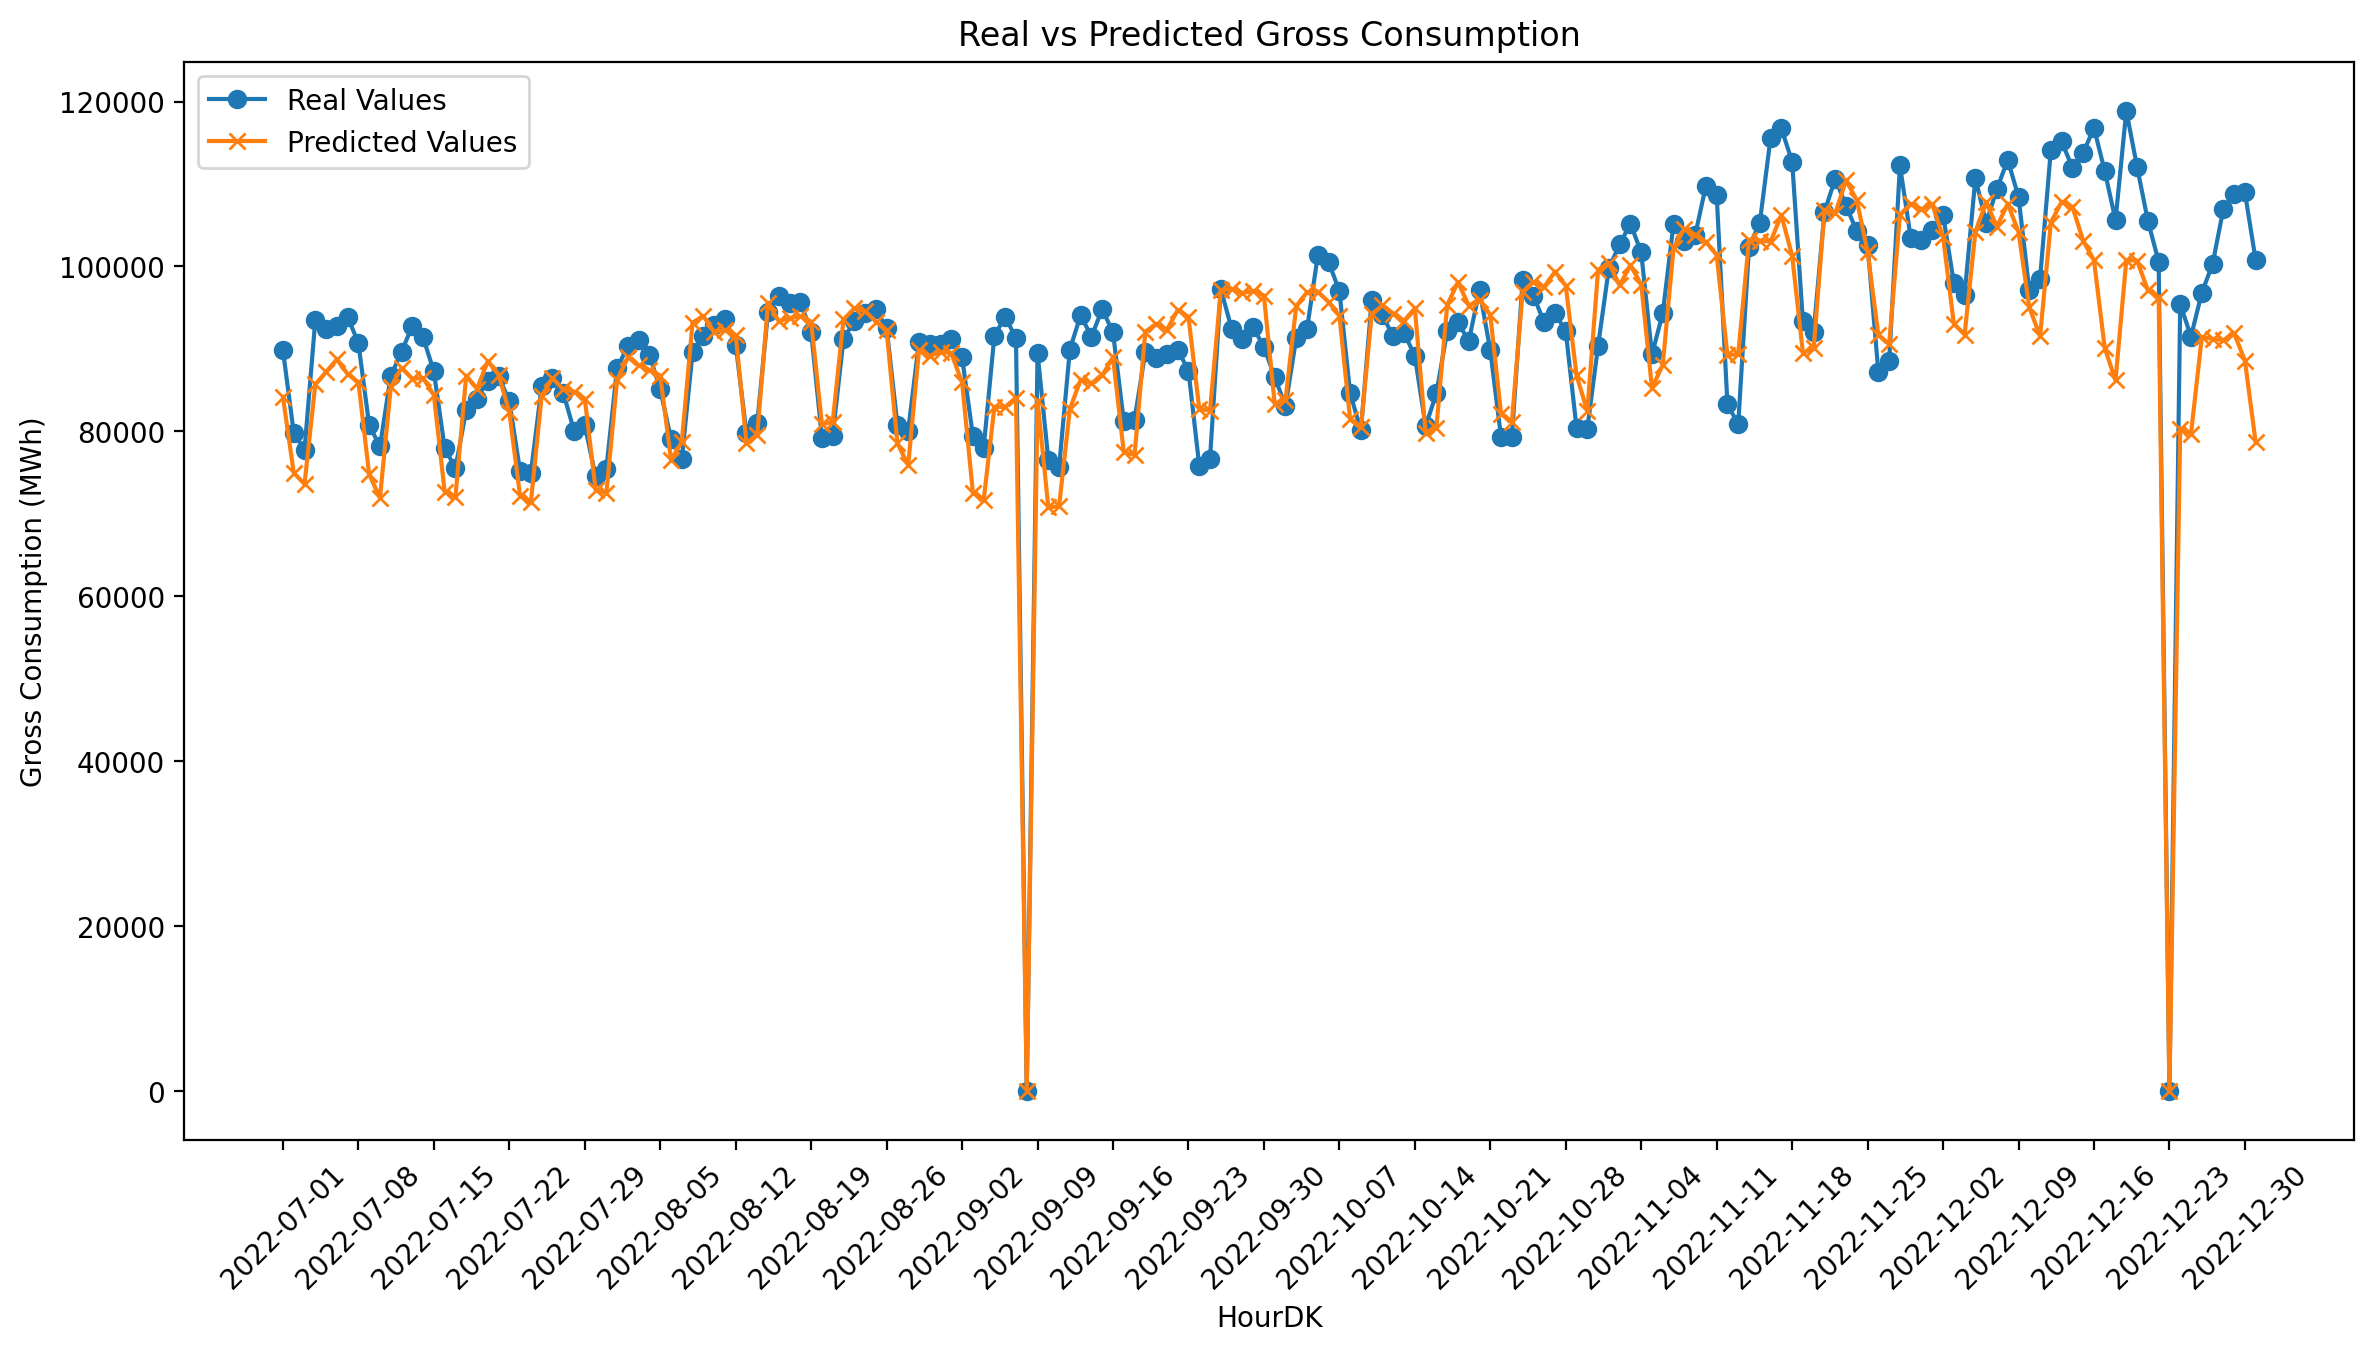

In [37]:
# Extract the date indices for the 1205th sequence
# Assuming y_pred_inv contains your test set predictions
# In our new setup, the last test set sequence would be:
single_sequence_date_indices = test_y_indices[len(y_pred_inv)-1]
single_sequence_date_str = test_y_dates[len(test_y_inv)-1]

# Plotting the real and predicted values for better visualization
plt.figure(figsize=(14, 7))

# Plotting the real values
plt.plot(np.array(single_sequence_true), label='Real Values', marker='o')

# Plotting the predicted values
plt.plot(single_sequence_pred, label='Predicted Values', marker='x')

# Adding labels, title, and legend
plt.xlabel('HourDK')
plt.ylabel('Gross Consumption (MWh)')
plt.title('Real vs Predicted Gross Consumption')
plt.legend()

# Rotating x-axis labels for better readability
plt.xticks(rotation=45)

# Set the dates on the x-axis
plt.xticks(np.arange(0, len(single_sequence_pred)), single_sequence_date_str)

# Display every 7th date for clarity
plt.xticks(np.arange(0, len(single_sequence_pred), 7), single_sequence_date_str[::7])

# Show the plot
plt.show()

## Saving and Loading the trained models

In [14]:
save_path = r'C:\Users\madsh\OneDrive\Dokumenter\kandidat\Fællesmappe\Speciale\Forecasting-energy-consumption-in-Denmark\multivariate Timerseries\Neural Netværk'

### Saving the model

In [ ]:
model_path = os.path.join(save_path, 'my_model.LR=0.01_2L_100-tahn-100-tahn.keras')
loaded_model.save(model_path)

### Load a model

In [15]:
model_path = os.path.join(save_path, 'my_model.LR=0.01_2L_50-tahn-50-tahn-V3.keras')
loaded_model = load_model(model_path)

## Model directory

### Model 1: my_model.LR=0.0001_2L_50-tahn-50-tahn.keras

In [59]:
model_path = os.path.join(save_path, 'my_model.LR=0.0001_2L_50-tahn-50-tahn.keras')
model_1 = load_model(model_path)
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 365, 50)           15000     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 184)               9384      
                                                                 
 activation_2 (Activation)   (None, 184)               0         
                                                                 
Total params: 44584 (174.16 KB)
Trainable params: 44584 (174.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [60]:
y_pred = model_1.predict(test_X)          #predicting using a old model loaded from save file
y_pred_inv = scaler.inverse_transform(y_pred)  #inversing the normalisation of the predictions
test_y_inv = scaler.inverse_transform(test_y)  #inversing the normalisation of the test values

y_pred_inv[np.where(test_y_inv == 0)] = 0      #replaces missing values with 0

#reshape predictions
y_pred_inv = y_pred_inv.reshape(-1, 1)
test_y_inv = test_y_inv.reshape(-1, 1)


print("\nMetrics of my_model.LR=0.0001_2L_50-tahn-50-tahn.keras predictions:")
metrics(test_y_inv, y_pred_inv)

1/1 [==============================] - 0s 276ms/step

Metrics of my_model.LR=0.0001_2L_50-tahn-50-tahn.keras predictions:
 MSE = 36995692.31503377
RMSE = 6082.408430468458
 MAE = 4640.214720951087
  %R^2% = 0.8174038110246967
 MAPE = 4.881392651194116%


C:\Users\madsh\AppData\Local\Temp\ipykernel_28396\2403727321.py:17: RuntimeWarning: invalid value encountered in divide
  mape_values = np.where(y_test != 0, abs((y_test - y_pred) / y_test), 0)


### Model 2: my_model.LR=0.0001_2L_50-tahn-50-tahn-V2.keras

In [61]:
model_path = os.path.join(save_path, 'my_model.LR=0.0001_2L_50-tahn-50-tahn-V2.keras')
model_2 = load_model(model_path)
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 365, 50)           15000     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 184)               9384      
                                                                 
 activation_2 (Activation)   (None, 184)               0         
                                                                 
Total params: 44584 (174.16 KB)
Trainable params: 44584 (174.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [62]:
y_pred = model_2.predict(test_X)          #predicting using a old model loaded from save file
y_pred_inv = scaler.inverse_transform(y_pred)  #inversing the normalisation of the predictions
test_y_inv = scaler.inverse_transform(test_y)  #inversing the normalisation of the test values

y_pred_inv[np.where(test_y_inv == 0)] = 0      #replaces missing values with 0

#reshape predictions
y_pred_inv = y_pred_inv.reshape(-1, 1)
test_y_inv = test_y_inv.reshape(-1, 1)


print("\nMetrics of my_model.LR=0.0001_2L_50-tahn-50-tahn-V2.keras predictions:")
metrics(test_y_inv, y_pred_inv)

1/1 [==============================] - 0s 279ms/step

Metrics of my_model.LR=0.0001_2L_50-tahn-50-tahn.keras predictions:
 MSE = 38357831.38906977
RMSE = 6193.369954158218
 MAE = 4642.869008366847
  %R^2% = 0.8106808282067146
 MAPE = 4.870764468605455%


C:\Users\madsh\AppData\Local\Temp\ipykernel_28396\2403727321.py:17: RuntimeWarning: invalid value encountered in divide
  mape_values = np.where(y_test != 0, abs((y_test - y_pred) / y_test), 0)


### Model 3: my_model.LR=0.01_2L_50-tahn-50-tahn-V3.keras

In [63]:
model_path = os.path.join(save_path, 'my_model.LR=0.01_2L_50-tahn-50-tahn-V3.keras')
model_3 = load_model(model_path)
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 365, 50)           15000     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 184)               9384      
                                                                 
 activation_2 (Activation)   (None, 184)               0         
                                                                 
Total params: 44584 (174.16 KB)
Trainable params: 44584 (174.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [65]:
y_pred = model_3.predict(test_X)          #predicting using a old model loaded from save file
y_pred_inv = scaler.inverse_transform(y_pred)  #inversing the normalisation of the predictions
test_y_inv = scaler.inverse_transform(test_y)  #inversing the normalisation of the test values

y_pred_inv[np.where(test_y_inv == 0)] = 0      #replaces missing values with 0

#reshape predictions
y_pred_inv = y_pred_inv.reshape(-1, 1)
test_y_inv = test_y_inv.reshape(-1, 1)


print("\nMetrics of my_model.LR=0.01_2L_50-tahn-50-tahn-V3.keras predictions:")
metrics(test_y_inv, y_pred_inv)

1/1 [==============================] - 0s 20ms/step

Metrics of my_model.LR=0.01_2L_50-tahn-50-tahn-V3.keras predictions:
 MSE = 38357831.38906977
RMSE = 6193.369954158218
 MAE = 4642.869008366847
  %R^2% = 0.8106808282067146
 MAPE = 4.870764468605455%


C:\Users\madsh\AppData\Local\Temp\ipykernel_28396\2403727321.py:17: RuntimeWarning: invalid value encountered in divide
  mape_values = np.where(y_test != 0, abs((y_test - y_pred) / y_test), 0)


### END